In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from keras.models import Model
from keras.layers import LSTM, Dense, Input, Dropout, Attention, Concatenate, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
# Existing code for data fetching
ticker = 'GME'
stockPrices = yf.download(ticker, '1981-01-01', '2024-07-17')

[*********************100%%**********************]  1 of 1 completed


### Feature Engineering and Data Preparation

In [3]:
# Define features that could indicate market manipulation
def add_manipulation_features(df):
    df['price_change'] = df['Close'].pct_change()
    df['volume_change'] = df['Volume'].pct_change()
    df['price_volume_ratio'] = df['Close'] / (df['Volume'] + 1)  # Adding 1 to avoid division by zero
    df['high_low_ratio'] = df['High'] / np.maximum(df['Low'], 0.01)  # Avoid division by zero
    df['volatility'] = df['Close'].rolling(window=20).std()
    return df

In [4]:
stockPrices = add_manipulation_features(stockPrices)
stockPrices.dropna(inplace=True)

In [5]:
stockPrices.isnull()

Open   High    Low  Close  Adj Close  Volume  price_change  \
Date                                                                      
2002-03-13  False  False  False  False      False   False         False   
2002-03-14  False  False  False  False      False   False         False   
2002-03-15  False  False  False  False      False   False         False   
2002-03-18  False  False  False  False      False   False         False   
2002-03-19  False  False  False  False      False   False         False   
...           ...    ...    ...    ...        ...     ...           ...   
2024-07-10  False  False  False  False      False   False         False   
2024-07-11  False  False  False  False      False   False         False   
2024-07-12  False  False  False  False      False   False         False   
2024-07-15  False  False  False  False      False   False         False   
2024-07-16  False  False  False  False      False   False         False   

            volume_change  price_volume_ratio  high_low_ratio  volatility  
Date                                                                       
2002-03-13          False               False           False       False  
2002-03-14          False               False           False       False  
2002-03-15          False               False           False       False  
2002-03-18          False               False           False       False  
2002-03-19          False               False           False       False  
...                   ...                 ...             ...         ...  
2024-07-10          False               False           False       False  
2024-07-11          False               False           False       False  
2024-07-12          False               False           False       False  
2024-07-15          False               False           False       False  
2024-07-16          False               False           False       False  

[5624 rows x 11 columns]

In [6]:
stockPrices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5624 entries, 2002-03-13 to 2024-07-16
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                5624 non-null   float64
 1   High                5624 non-null   float64
 2   Low                 5624 non-null   float64
 3   Close               5624 non-null   float64
 4   Adj Close           5624 non-null   float64
 5   Volume              5624 non-null   int64  
 6   price_change        5624 non-null   float64
 7   volume_change       5624 non-null   float64
 8   price_volume_ratio  5624 non-null   float64
 9   high_low_ratio      5624 non-null   float64
 10  volatility          5624 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 527.2 KB


In [7]:
stockPrices.dtypes

Open                  float64
High                  float64
Low                   float64
Close                 float64
Adj Close             float64
Volume                  int64
price_change          float64
volume_change         float64
price_volume_ratio    float64
high_low_ratio        float64
volatility            float64
dtype: object

In [8]:
stockPrices.shape

(5624, 11)

In [9]:
stockPrices.size

61864

In [10]:
stockPrices.describe()

Open         High          Low        Close    Adj Close  \
count  5624.000000  5624.000000  5624.000000  5624.000000  5624.000000   
mean      9.385349     9.702969     9.072118     9.366657     8.030520   
std      10.393533    11.043762     9.752424    10.300896    10.546108   
min       0.712500     0.735000     0.642500     0.700000     0.638794   
25%       3.704375     3.774375     3.637500     3.704375     2.944005   
50%       5.985000     6.062500     5.880000     5.980000     4.241859   
75%      10.565625    10.760625    10.385625    10.591250     7.644338   
max      94.927498   120.750000    72.877502    86.877502    86.877502   

             Volume  price_change  volume_change  price_volume_ratio  \
count  5.624000e+03   5624.000000    5624.000000        5.624000e+03   
mean   1.455005e+07      0.001693       0.157089        1.364871e-06   
std    2.985896e+07      0.053563       0.865286        1.959671e-06   
min    2.600000e+05     -0.600000      -0.907167        8.004228e-09   
25%    5.405925e+06     -0.016124      -0.254561        3.592525e-07   
50%    9.638000e+06      0.000000      -0.021822        6.866998e-07   
75%    1.520590e+07      0.016190       0.315908        1.392745e-06   
max    7.886316e+08      1.348358      22.107538        2.330986e-05   

       high_low_ratio   volatility  
count     5624.000000  5624.000000  
mean         1.049890     0.793911  
std          0.075588     2.127895  
min          1.006806     0.024191  
25%          1.024028     0.133164  
50%          1.034892     0.245159  
75%          1.054721     0.477112  
max          4.302895    26.072464

In [11]:
stockPrices.isna()

Open   High    Low  Close  Adj Close  Volume  price_change  \
Date                                                                      
2002-03-13  False  False  False  False      False   False         False   
2002-03-14  False  False  False  False      False   False         False   
2002-03-15  False  False  False  False      False   False         False   
2002-03-18  False  False  False  False      False   False         False   
2002-03-19  False  False  False  False      False   False         False   
...           ...    ...    ...    ...        ...     ...           ...   
2024-07-10  False  False  False  False      False   False         False   
2024-07-11  False  False  False  False      False   False         False   
2024-07-12  False  False  False  False      False   False         False   
2024-07-15  False  False  False  False      False   False         False   
2024-07-16  False  False  False  False      False   False         False   

            volume_change  price_volume_ratio  high_low_ratio  volatility  
Date                                                                       
2002-03-13          False               False           False       False  
2002-03-14          False               False           False       False  
2002-03-15          False               False           False       False  
2002-03-18          False               False           False       False  
2002-03-19          False               False           False       False  
...                   ...                 ...             ...         ...  
2024-07-10          False               False           False       False  
2024-07-11          False               False           False       False  
2024-07-12          False               False           False       False  
2024-07-15          False               False           False       False  
2024-07-16          False               False           False       False  

[5624 rows x 11 columns]

In [12]:
# Remove infinite values and clip extreme values
def clean_data(df):
    for column in df.columns:
        df[column] = df[column].replace([np.inf, -np.inf], np.nan)
        df[column] = df[column].fillna(df[column].mean())
        lower_bound = df[column].quantile(0.001)
        upper_bound = df[column].quantile(0.999)
        df[column] = df[column].clip(lower_bound, upper_bound)
    return df

In [13]:
stockPrices = clean_data(stockPrices)

In [14]:
def prepare_data(data, window_size=50):
    X, y_price, y_manip = [], [], []
    features = ['Close', 'price_change', 'volume_change', 'price_volume_ratio', 'high_low_ratio', 'volatility']
    
    for i in range(window_size, len(data)):
        X.append(data[features][i-window_size:i].values)
        y_price.append(data['Close'][i])
        y_manip.append(1 if abs(data['price_change'][i]) > 0.1 or abs(data['volume_change'][i]) > 0.5 else 0)
    
    return np.array(X), np.array(y_price), np.array(y_manip)

In [15]:
X, y_price, y_manip = prepare_data(stockPrices)

C:\Users\Loricson\AppData\Local\Temp\ipykernel_32916\2702377953.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_price.append(data['Close'][i])
C:\Users\Loricson\AppData\Local\Temp\ipykernel_32916\2702377953.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_manip.append(1 if abs(data['price_change'][i]) > 0.1 or abs(data['volume_change'][i]) > 0.5 else 0)
C:\Users\Loricson\AppData\Local\Temp\ipykernel_32916\2702377953.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc

### Train-test Split

In [16]:
# Split the data
X_train, X_test, y_price_train, y_price_test, y_manip_train, y_manip_test = train_test_split(
    X, y_price, y_manip, test_size=0.2, shuffle=False)

In [17]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

### Create Model

In [18]:
# Define the combined model
def create_combined_model(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(64, return_sequences=True)(inputs)
    lstm_out = LSTM(32, return_sequences=True)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    attention = Attention()([lstm_out, lstm_out])
    combined = Concatenate()([lstm_out, attention])
    lstm_out = LSTM(16)(combined)
    
    price_output = Dense(1, name='price_output')(lstm_out)
    manip_output = Dense(1, activation='sigmoid', name='manip_output')(lstm_out)
    
    model = Model(inputs=inputs, outputs=[price_output, manip_output])
    model.compile(optimizer=Adam(),
                  loss={'price_output': 'mse', 'manip_output': 'binary_crossentropy'},
                  loss_weights={'price_output': 1.0, 'manip_output': 0.5},
                  metrics={'price_output': 'mae', 'manip_output': 'accuracy'})
    return model

In [19]:
model = create_combined_model((X_train.shape[1], X_train.shape[2]))

In [20]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=12)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
model_checkpoint = ModelCheckpoint('best_combined_model.keras', save_best_only=True)

In [21]:
history = model.fit(X_train_scaled, 
                    {'price_output': y_price_train, 'manip_output': y_manip_train},
                    validation_split=0.1,
                    epochs=50, 
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - loss: 31.1336 - manip_output_accuracy: 0.3445 - price_output_mae: 4.7747 - val_loss: 1.1814 - val_manip_output_accuracy: 0.5135 - val_price_output_mae: 0.7204 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 13.1481 - manip_output_accuracy: 0.7160 - price_output_mae: 2.4466 - val_loss: 1.8707 - val_manip_output_accuracy: 0.6502 - val_price_output_mae: 0.9751 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 8.4300 - manip_output_accuracy: 0.7569 - price_output_mae: 1.7719 - val_loss: 0.7349 - val_manip_output_accuracy: 0.7578 - val_price_output_mae: 0.5296 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 7.0412 - manip_output_accuracy: 0.7610 - price_output_mae: 1.5442 - val_loss: 0.6967 - val_manip_output_accuracy: 0.7578 - val_price_output_mae: 0.4742 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - los

### Make Predictions

In [22]:
# Function to make predictions
def make_predictions(model, X):
    price_pred, manip_pred = model.predict(X)
    return price_pred.flatten(), manip_pred.flatten()

In [23]:
# Make predictions on test data
price_pred, manip_pred = make_predictions(model, X_test_scaled)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


### Evaluation Model Performance

In [24]:
price_mae = mean_absolute_error(y_price_test, price_pred)
manip_accuracy = accuracy_score(y_manip_test, (manip_pred > 0.5).astype(int))

In [25]:
print(f"Price Prediction MAE: {price_mae}")
print(f"Manipulation Detection Accuracy: {manip_accuracy}")

Price Prediction MAE: 21.20754009410689
Manipulation Detection Accuracy: 0.4484304932735426


### Future Prediction

In [40]:
def predict_future(model, last_window, scaler, steps=30):
    future_pred_price = []
    future_pred_manip = []
    current_window = last_window.copy()

    for _ in range(steps):
        # Scale the current window
        scaled_window = scaler.transform(current_window.reshape(-1, current_window.shape[-1]))
        scaled_window = scaled_window.reshape(1, current_window.shape[1], current_window.shape[2])
        
        # Make predictions
        pred_price, pred_manip = model.predict(scaled_window)
        
        future_pred_price.append(pred_price[0][0])
        future_pred_manip.append(pred_manip[0][0])
        
        # Update the window for next prediction
        new_row = current_window[0, -1, :].copy()
        new_row[0] = pred_price[0][0]  # Assuming 'Close' is the first feature
        current_window = np.roll(current_window, -1, axis=1)
        current_window[0, -1, :] = new_row

    return np.array(future_pred_price), np.array(future_pred_manip)

In [41]:
last_window = X_test_scaled[-1:].reshape(1, X_test_scaled.shape[1], X_test_scaled.shape[2])

In [42]:
future_prices, future_manip = predict_future(model, last_window, scaler, steps=30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

In [45]:
# Future predictions DataFrame
future_dates = pd.date_range(start=stockPrices.index[-1] + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({
    'Predicted_Price': future_prices,
    'Manipulation_Probability': future_manip
}, index=future_dates)

### Plot the Predicted and Detected Graph

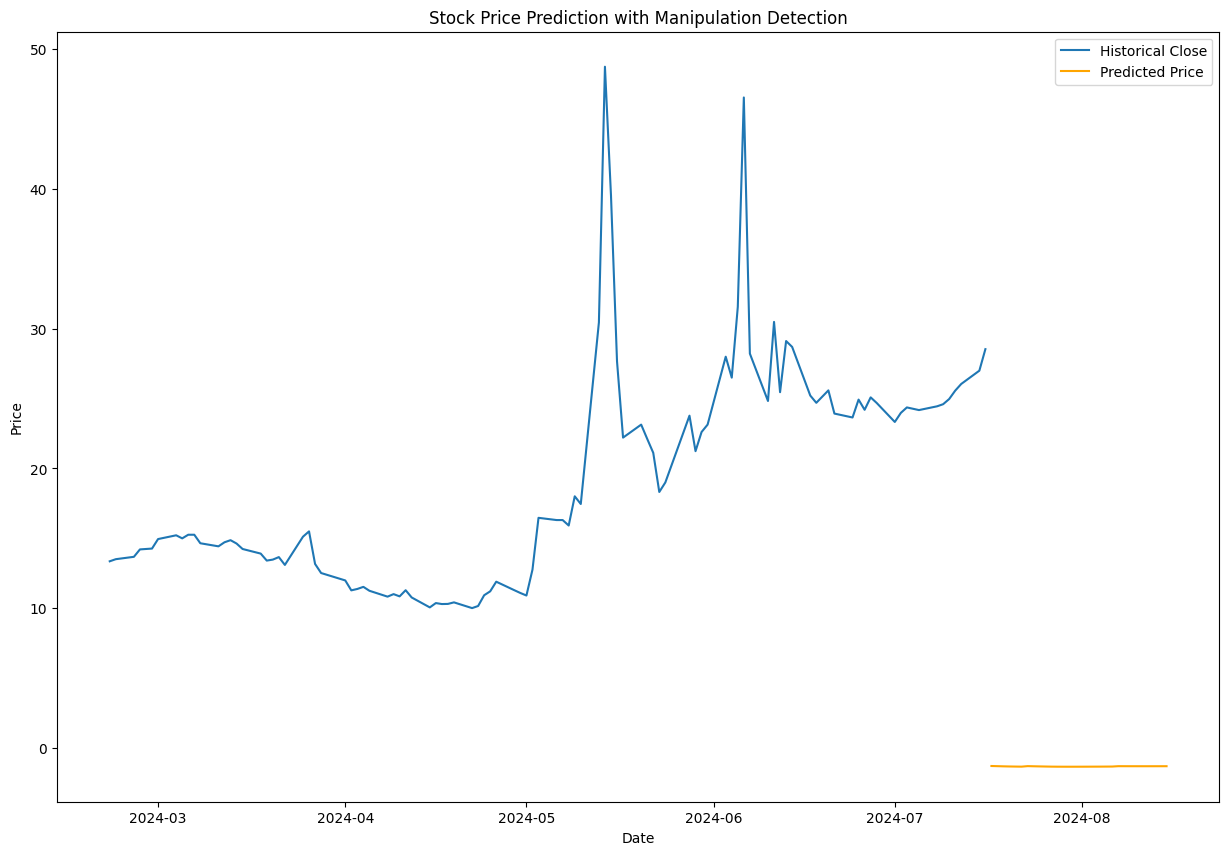

In [46]:
plt.figure(figsize=(15, 10))
plt.plot(stockPrices.index[-100:], stockPrices['Close'][-100:], label='Historical Close')
plt.plot(future_df.index, future_df['Predicted_Price'], label='Predicted Price', color='orange')
plt.title('Stock Price Prediction with Manipulation Detection')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

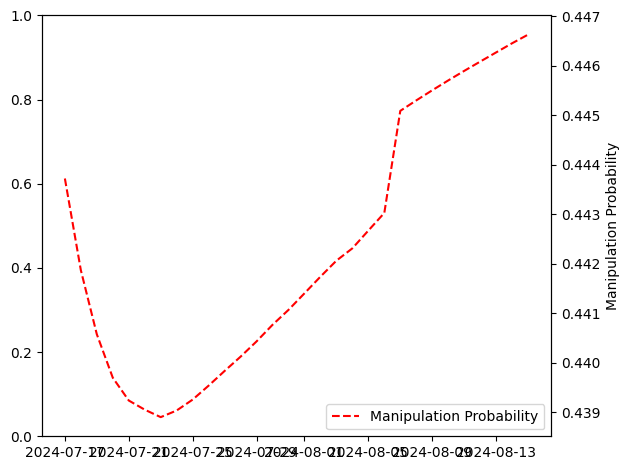

In [47]:
# Plot manipulation probability
ax2 = plt.twinx()
ax2.plot(future_df.index, future_df['Manipulation_Probability'], 'r--', label='Manipulation Probability')
ax2.set_ylabel('Manipulation Probability')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [48]:
high_manip_days = future_df[future_df['Manipulation_Probability'] > 0.7]
if not high_manip_days.empty:
    print("\nDays with high manipulation probability:")
    print(high_manip_days)
else:
    print("\nNo days with high manipulation probability detected.")


No days with high manipulation probability detected.
